# Quantum Teleportation
The quantum teleportation protocol was first proposed in [1]. Suppose Alice has the state $\vert \psi \rangle$ and is trying to send $\vert \psi \rangle$ to Bob. The no cloning theorem [2] says that $\vert \psi \rangle$ cannot be sent via copying. The proposed quantum teleportation algorithm serves to "teleport" $\vert \psi \rangle$ from Alice to Bob, meaning that Alice's copy is destroyed when $\vert \psi \rangle$ has been sent to Bob. Destroy here means the destruction of information, not the physical qubit.

This jupyter notebook explains in greater detail the implementation in teleport.py. In the quantum teleportation protocol, there are three qubits involved:
1. Qubit $\psi$ held by Alice, to be transmitted to Bob
2. Alice's working qubit $b_1$
3. Bob's qubit $b_2$, which will hold the teleported $\psi$

The steps involved in the quantum teleportation protocol are as follow: 
1. Entangle Alice's $b_1$ with Bob's $b_2$, creating a bell pair
2. Apply CNOT (conditional NOT) on $b_1$, with $\psi$ as the controlling bit
3. Put $\psi$ into superposition using the Hadamard operator
4. Alice measures $\psi$ and $b_1$. The measured results are transmitted via classical channels to Bob
5. Depending on the measured results received, Bob will choose to do none/one/both of the X and Z unitary operations on $b_2$

Bob's $b_2$ now holds the teleported state $\psi$

In [1]:
import projectq
from projectq.backends import CircuitDrawer
from projectq.ops import H, Rz, CNOT, X, Z, Measure
from projectq.meta import Dagger, Control

from pathlib import Path

## The following two functions are lifted from teleport.py
The create_state() function sets up the $\psi$ state. In the function, $b_1$ and $b_2$ are created and initialized to $\vert 0 \rangle$. After the H | b1 operation, $b_1 = \frac{1}{\sqrt{2}} \left( \vert 0 \rangle + \vert 1 \rangle \right)$. After the CNOT | (b1, b2) operation, b1 and b2 becomes the entangled Bell pair $\frac{1}{\sqrt{2}} \left( \vert 00 \rangle + \vert 11 \rangle \right)$

In [2]:
# define our state-creation routine, which transforms a |0> to the state
# we would like to send. Bob can then try to uncompute it and, if he
# arrives back at |0>, we know that the teleportation worked.
def create_state(eng, qb):
    H | qb
    Rz(1.21) | qb
    
def create_bell_pair(eng):
    """
    Returns a Bell-pair (two qubits in state :math:`|A\rangle \otimes |B
    \rangle = \frac 1{\sqrt 2} \left( |0\rangle\otimes|0\rangle + |1\rangle
    \otimes|1\rangle \right)`).

    Args:
        eng (MainEngine): MainEngine from which to allocate the qubits.

    Returns:
        bell_pair (tuple<Qubits>): The Bell-pair.
    """
    b1 = eng.allocate_qubit()
    b2 = eng.allocate_qubit()

    H | b1
    CNOT | (b1, b2)

    return b1, b2

In [3]:
def make_teleportation_circuit(eng, verbose=True):
    # Step 1: make a Bell-pair
    b1, b2 = create_bell_pair(eng) 
    
    # Alice creates a nice state to send
    psi = eng.allocate_qubit()
    if verbose:
        print("Alice is creating her state from scratch, i.e., |0>.")
    create_state(eng, psi)    
    
    # Implements step 2 of the protocol
    CNOT | (psi, b1)
    if verbose:
        print("Alice entangled her qubit with her share of the Bell-pair.")

    # Step 3 of the protocol, putting psi into superposition
    H | psi    
    
    # Step 4 of the protocol: measure psi and b1, whose outcomes
    # which will be communicated via classical channels to Bob
    Measure | psi
    Measure | b1    
    
    msg_to_bob = [int(psi), int(b1)]
    if verbose:
        print("Alice is sending the message {} to Bob.".format(msg_to_bob)) 

    # Sstep 5 of the protocol. After receiving the measured results, 
    # Bob will proceed to apply the necessary operations
    with Control(eng, b1):
        X | b2
    with Control(eng, psi):
        Z | b2  

    # Now Bob's b2 holds the psi state
    return psi, b1, b2

## Visualize the quantum teleportation circuit
Contains the same circuit drawing function as teleport_circuit.py. Additional code serves to draw the circuit in jupyter notebook

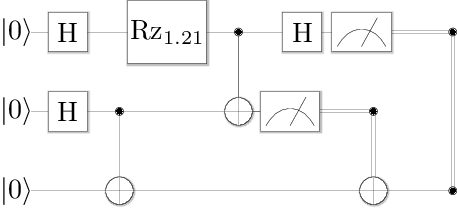

In [4]:
drawing_engine = CircuitDrawer()
locations = {0: 1, 1: 2, 2: 0}
drawing_engine.set_qubit_locations(locations)
eng = projectq.MainEngine(drawing_engine)
ψ, b1, b2 = make_teleportation_circuit(eng, False)
eng.flush()

p = Path('diagram')
if not p.exists(): #if the diagram directory doesn't exist, create it
    p.mkdir()
with open('diagram/teleport.tex', 'w') as f:
    latex = drawing_engine.get_latex() #get circuit diagram as latex
    f.write(latex) 
#Change the pdf scale to 1.8 from 0.8 to have better visual effect
!sed -i 's@tikzpicture\}\[scale=0.8@tikzpicture\}\[scale=2.8@g' diagram/teleport.tex
!cd diagram; pdflatex teleport.tex  > /dev/null #convert tex to latex, piping to /dev/null to silent output      

#Wand package needed to convert pdf to image
from wand.image import Image as WImage
img = WImage(filename='diagram/teleport.pdf')
img

In [5]:
#Uncompute b2 so that b2 returns to a computational state and can be safely deleted, 
#otherwise an error will be thrown
with Dagger(eng):
    create_state(eng, b2)
del b2
eng.flush() 

## Run the quantum teleportation circuit

In [6]:
main_eng = projectq.MainEngine()
ψ, b1, b2 = make_teleportation_circuit(eng)

#Verify that psi has indeed been teleported to b2
with Dagger(eng):
    create_state(eng, b2)
del b2
eng.flush() 

Alice is creating her state from scratch, i.e., |0>.
Alice entangled her qubit with her share of the Bell-pair.
Alice is sending the message [0, 0] to Bob.


Note that after getting $\psi, b_1, b_2$ from calling make_teleportation_circuit(eng), we still need to verify that $b_2$ is in the teleported state $\psi$. Using ProjectQ's Dagger construct, we uncompute $b_2$ by reversing the create state operation. If the teleportation is successful, then the uncompute operation should return $b_2$ to its original $\vert 0 \rangle$ state. Therefore deleting $b_2$ should go smoothly. If the teleportation is unsuccessful, then the supposed uncompute operation will not return $b_2$ to its original $\vert 0 \rangle$ state. As explained in simulator_tutorial.ipynb, deletion will throw an error.

## Underlying mathematics

In step 1 of the protocol, Alice's $b_1$ and Bob's $b_2$ entangled states are described by $\frac{1}{\sqrt{2}} \left( \vert 00 \rangle + \vert 11 \rangle \right)$

Suppose $\psi$ is in the arbitrary state $\psi = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$ after calling create_state(). In step 2 of the protocol, after applying CNOT on $b_1$ with $\psi$ as the controlling bit,

The joint state of $\psi$ and $b_1$ is now described by 
$$ \frac{1}{\sqrt{2}} \left[ \alpha \vert 0 \rangle \vert 00 \rangle + \alpha \vert 0 \rangle \vert 11 \rangle + \beta \vert 1\rangle \vert 10 \rangle + \beta \vert 1 \rangle \vert 01 \rangle \right]$$

In step 3 of the protocol, after applying the Hadamard operation on $\psi$, $\psi \rightarrow \frac{1}{\sqrt{2}} \left[ \alpha \left( \vert 0 \rangle + \vert 1 \rangle \right) + \beta \left( \vert 0 \rangle - \vert 1 \rangle \right) \right]$ 

The full state (of $\psi$, $b_1$ and $b_2$) now becomes
$$ \frac{1}{\sqrt{2}} \left[ \alpha \left( \vert 0 \rangle + \vert 1 \rangle \right) \vert  00 \rangle + \alpha \left( \vert 0 \rangle + \vert 1 \rangle \right) \vert 11 \rangle + \beta \left( \vert 0 \rangle - \vert 1 \rangle \right) \vert 10 \rangle + \beta \left( \vert 0 \rangle - \vert 1 \rangle \right) \vert \rangle 01 \rangle \right]$$

$$ = \frac{1}{\sqrt{2}} \left[ \alpha \vert 000 \rangle + \alpha \vert 100 \rangle + \alpha \vert 011 \rangle + \alpha \vert 111 \rangle + \beta \vert 010 \rangle - \beta \vert 110 \rangle + \beta \vert 001 \rangle - \beta \vert 101 \rangle \right] $$

$$ = \frac{1}{{2}} \left[ \left(\alpha \vert 000 \rangle + \beta \vert 001 \rangle \right) + \left(\alpha \vert 011 \rangle + \beta \vert 010 \rangle \right) + \left(\alpha \vert 100 \rangle - \beta \vert 101 \rangle \right) + \left(\alpha \vert 111 \rangle - \beta \vert 110 \rangle \right) \right]$$

$$ = \frac{1}{{2}} \left[ \vert 00 \rangle \left(\alpha \vert 0 \rangle + \beta \vert 1 \rangle \right) + \vert 01 \rangle \left( \beta \vert 0 \rangle + \alpha \vert 1 \rangle \right) + \vert 10 \rangle \left( \alpha \vert 0 \rangle - \beta \vert 1 \rangle \right) + \vert 11 \rangle \left( \alpha \vert 1 \rangle - \beta \vert 0 \rangle \right) \right]$$

$$ = \frac{1}{{2}} \left[ \vert 00 \rangle  \vert \psi \rangle + \vert 01 \rangle X \vert \psi \rangle + \vert 10 \rangle Z \vert \psi \rangle + \vert 11 \rangle XZ \vert \psi \rangle \right]$$

In step 4 of the protocol, the measured $\psi$ and $b_1$ will be one of the four possibilities: $\{\vert 00 \rangle, \vert 01 \rangle, \vert 10 \rangle, \vert 11 \rangle \}$. The measured results are transmitted to Bob via classical channels.

We see that Bob is getting $\psi$ up to some unitary transform. For instance, if $\psi$ and Alice's $b_1$ are measured to be $\vert 01 \rangle$, then Bob is getting $X \vert \psi \rangle$. In step 5 of the protocol, Bob will proceed to apply the following operations depending on what he receives from Alice:

1. $\vert 00 \rangle$. Bob does nothing and gets $\psi$
2. $\vert 01 \rangle$. Bob applies the X operator and gets $\psi$
3. $\vert 10 \rangle$. Bob applies the Z operator and gets $\psi$
4. $\vert 11 \rangle$. Bob applies the ZX operator and gets $\psi$

Both X and Z are unitary and symmetrical, meaning that applying these operations twice will result in identity and hence the above steps.

# References

1. Charles H. Bennett, Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and William K. Wootters Phys. Rev. Lett. 70, 1895 – Published 29 March 1993

2. William K Wootters and Wojciech H Zurek. A single quantum cannot be cloned. Nature, 299(5886):802–803, 1982